### This notebook is used to create chunks of the original data
The chunking splits longer audio clips into short segments. The segments are created with overlap. The signla to noise ratio is used to determine which chunks have bird song in them and which are just noise. Some the noise chunks are saved and used in training.

In [19]:
import numpy as np
import pandas as pd
import random
import math

import os
from pathlib import Path
import shutil

import cv2
from tqdm import tqdm

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#### Signla to Noise function

In [2]:
def signal2noise_logspec_median(spec, freq_margin_db=10.0, time_margin_db=10.0):
    """
    Estimate SNR for a log-mel spectrogram by applying median-based thresholds
    along frequency (rows) and time (columns), with morphological cleaning.
    
    Args:
        spec (np.ndarray): Log-mel spectrogram (shape: [n_mels, time_frames], in dB)
        freq_margin_db (float): Margin above freq median for thresholding (dB)
        time_margin_db (float): Margin above time median for thresholding (dB)
        
    Returns:
        s2n (float): Estimated signal-to-noise ratio in [0,1]
    """
    spec = spec.copy()

    # Median per frequency bin (row-wise median over time)
    row_median = np.median(spec, axis=1, keepdims=True)  # shape (n_mels, 1)
    # Median per time frame (column-wise median over freq)
    col_median = np.median(spec, axis=0, keepdims=True)  # shape (1, time_frames)

    # Create masks where values exceed median + margin
    freq_mask = spec >= (row_median + freq_margin_db)
    time_mask = spec >= (col_median + time_margin_db)

    # Combine masks: pixel counts as signal if above both frequency and time thresholds
    combined_mask = np.logical_and(freq_mask, time_mask).astype(np.uint8)  # binary mask 0/1

    # Median blur to reduce salt & pepper noise
    combined_mask = cv2.medianBlur(combined_mask, 3)

    # Morphological close to fill gaps
    kernel = np.ones((3, 3), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

    # Calculate signal-to-noise ratio as fraction of signal pixels
    s2n = combined_mask.sum() / combined_mask.size

    return s2n

#### Test chunking on single file

In [3]:
def test_chunking_single_spectrogram(
    file_path,
    output_root,
    chunk_size=512,
    stride=256,
    snr_threshold=0.1,
):
    
    os.makedirs(output_root, exist_ok=True)

    metadata_records = []

    spec = np.load(file_path)
    num_frames = spec.shape[1]
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    chunk_idx = 0

    for start in range(0, num_frames - chunk_size + 1, stride):
        chunk = spec[:, start:start + chunk_size]
        s2n = signal2noise_logspec_median(chunk)

        print(f"Chunk {chunk_idx} | Start: {start} | SNR: {s2n:.4f}")

        #if s2n >= snr_threshold:
        chunk_filename = f"{base_name}_chunk{chunk_idx}.npy"
        chunk_path = os.path.join(output_root, chunk_filename)
        np.save(chunk_path, chunk)

        metadata_records.append({
            "chunk_index": chunk_idx,
            "start_frame": start,
            "end_frame": start + chunk_size,
            "snr": s2n,
            "chunk_path": chunk_path
        })

        chunk_idx += 1

    df = pd.DataFrame(metadata_records)
    metadata_path = os.path.join(output_root, f"{base_name}_metadata.csv")
    df.to_csv(metadata_path, index=False)
    print(f"\nSaved test metadata to {metadata_path}")

In [4]:
test_chunking_single_spectrogram(
    file_path="../data/processed_audio/npy_spectrograms/Black Cuckoo/Black_Cuckoo_09.npy",
    output_root="../data/processed_audio/test_chunks",
    chunk_size=86,
    stride=43,
    snr_threshold=0.1
)

Chunk 0 | Start: 0 | SNR: 0.0120
Chunk 1 | Start: 43 | SNR: 0.0062
Chunk 2 | Start: 86 | SNR: 0.0040
Chunk 3 | Start: 129 | SNR: 0.0157
Chunk 4 | Start: 172 | SNR: 0.0166
Chunk 5 | Start: 215 | SNR: 0.0114
Chunk 6 | Start: 258 | SNR: 0.0195
Chunk 7 | Start: 301 | SNR: 0.0203
Chunk 8 | Start: 344 | SNR: 0.0115
Chunk 9 | Start: 387 | SNR: 0.0089
Chunk 10 | Start: 430 | SNR: 0.0258
Chunk 11 | Start: 473 | SNR: 0.0255
Chunk 12 | Start: 516 | SNR: 0.0082
Chunk 13 | Start: 559 | SNR: 0.0000
Chunk 14 | Start: 602 | SNR: 0.0035
Chunk 15 | Start: 645 | SNR: 0.0118
Chunk 16 | Start: 688 | SNR: 0.0152
Chunk 17 | Start: 731 | SNR: 0.0137
Chunk 18 | Start: 774 | SNR: 0.0079
Chunk 19 | Start: 817 | SNR: 0.0129
Chunk 20 | Start: 860 | SNR: 0.0144
Chunk 21 | Start: 903 | SNR: 0.0057
Chunk 22 | Start: 946 | SNR: 0.0011
Chunk 23 | Start: 989 | SNR: 0.0011
Chunk 24 | Start: 1032 | SNR: 0.0078
Chunk 25 | Start: 1075 | SNR: 0.0124
Chunk 26 | Start: 1118 | SNR: 0.0129
Chunk 27 | Start: 1161 | SNR: 0.0269
Ch

#### Visualize Chunks
This will allow us to tune the snr_threshold, and the signal2noise function

In [5]:
def plot_chunks_from_metadata(metadata_csv, num_chunks=None):
    df = pd.read_csv(metadata_csv)
    df = df.sort_values(by="snr", ascending=False)

    if num_chunks is not None:
        df = df.head(num_chunks)

    total = len(df)
    cols = 5
    rows = math.ceil(total / cols)

    plt.figure(figsize=(3 * cols, 3 * rows))
    for i, (_, row) in enumerate(df.iterrows()):
        chunk = np.load(row["chunk_path"])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(chunk, origin="lower", aspect="auto", cmap="magma")
        plt.title(f"SNR: {row['snr']:.4f}", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Chunk 0 | Start: 0 | SNR: 0.0120
Chunk 1 | Start: 43 | SNR: 0.0062
Chunk 2 | Start: 86 | SNR: 0.0040
Chunk 3 | Start: 129 | SNR: 0.0157
Chunk 4 | Start: 172 | SNR: 0.0166
Chunk 5 | Start: 215 | SNR: 0.0114
Chunk 6 | Start: 258 | SNR: 0.0195
Chunk 7 | Start: 301 | SNR: 0.0203
Chunk 8 | Start: 344 | SNR: 0.0115
Chunk 9 | Start: 387 | SNR: 0.0089
Chunk 10 | Start: 430 | SNR: 0.0258
Chunk 11 | Start: 473 | SNR: 0.0255
Chunk 12 | Start: 516 | SNR: 0.0082
Chunk 13 | Start: 559 | SNR: 0.0000
Chunk 14 | Start: 602 | SNR: 0.0035
Chunk 15 | Start: 645 | SNR: 0.0118
Chunk 16 | Start: 688 | SNR: 0.0152
Chunk 17 | Start: 731 | SNR: 0.0137
Chunk 18 | Start: 774 | SNR: 0.0079
Chunk 19 | Start: 817 | SNR: 0.0129
Chunk 20 | Start: 860 | SNR: 0.0144
Chunk 21 | Start: 903 | SNR: 0.0057
Chunk 22 | Start: 946 | SNR: 0.0011
Chunk 23 | Start: 989 | SNR: 0.0011
Chunk 24 | Start: 1032 | SNR: 0.0078
Chunk 25 | Start: 1075 | SNR: 0.0124
Chunk 26 | Start: 1118 | SNR: 0.0129
Chunk 27 | Start: 1161 | SNR: 0.0269
Ch

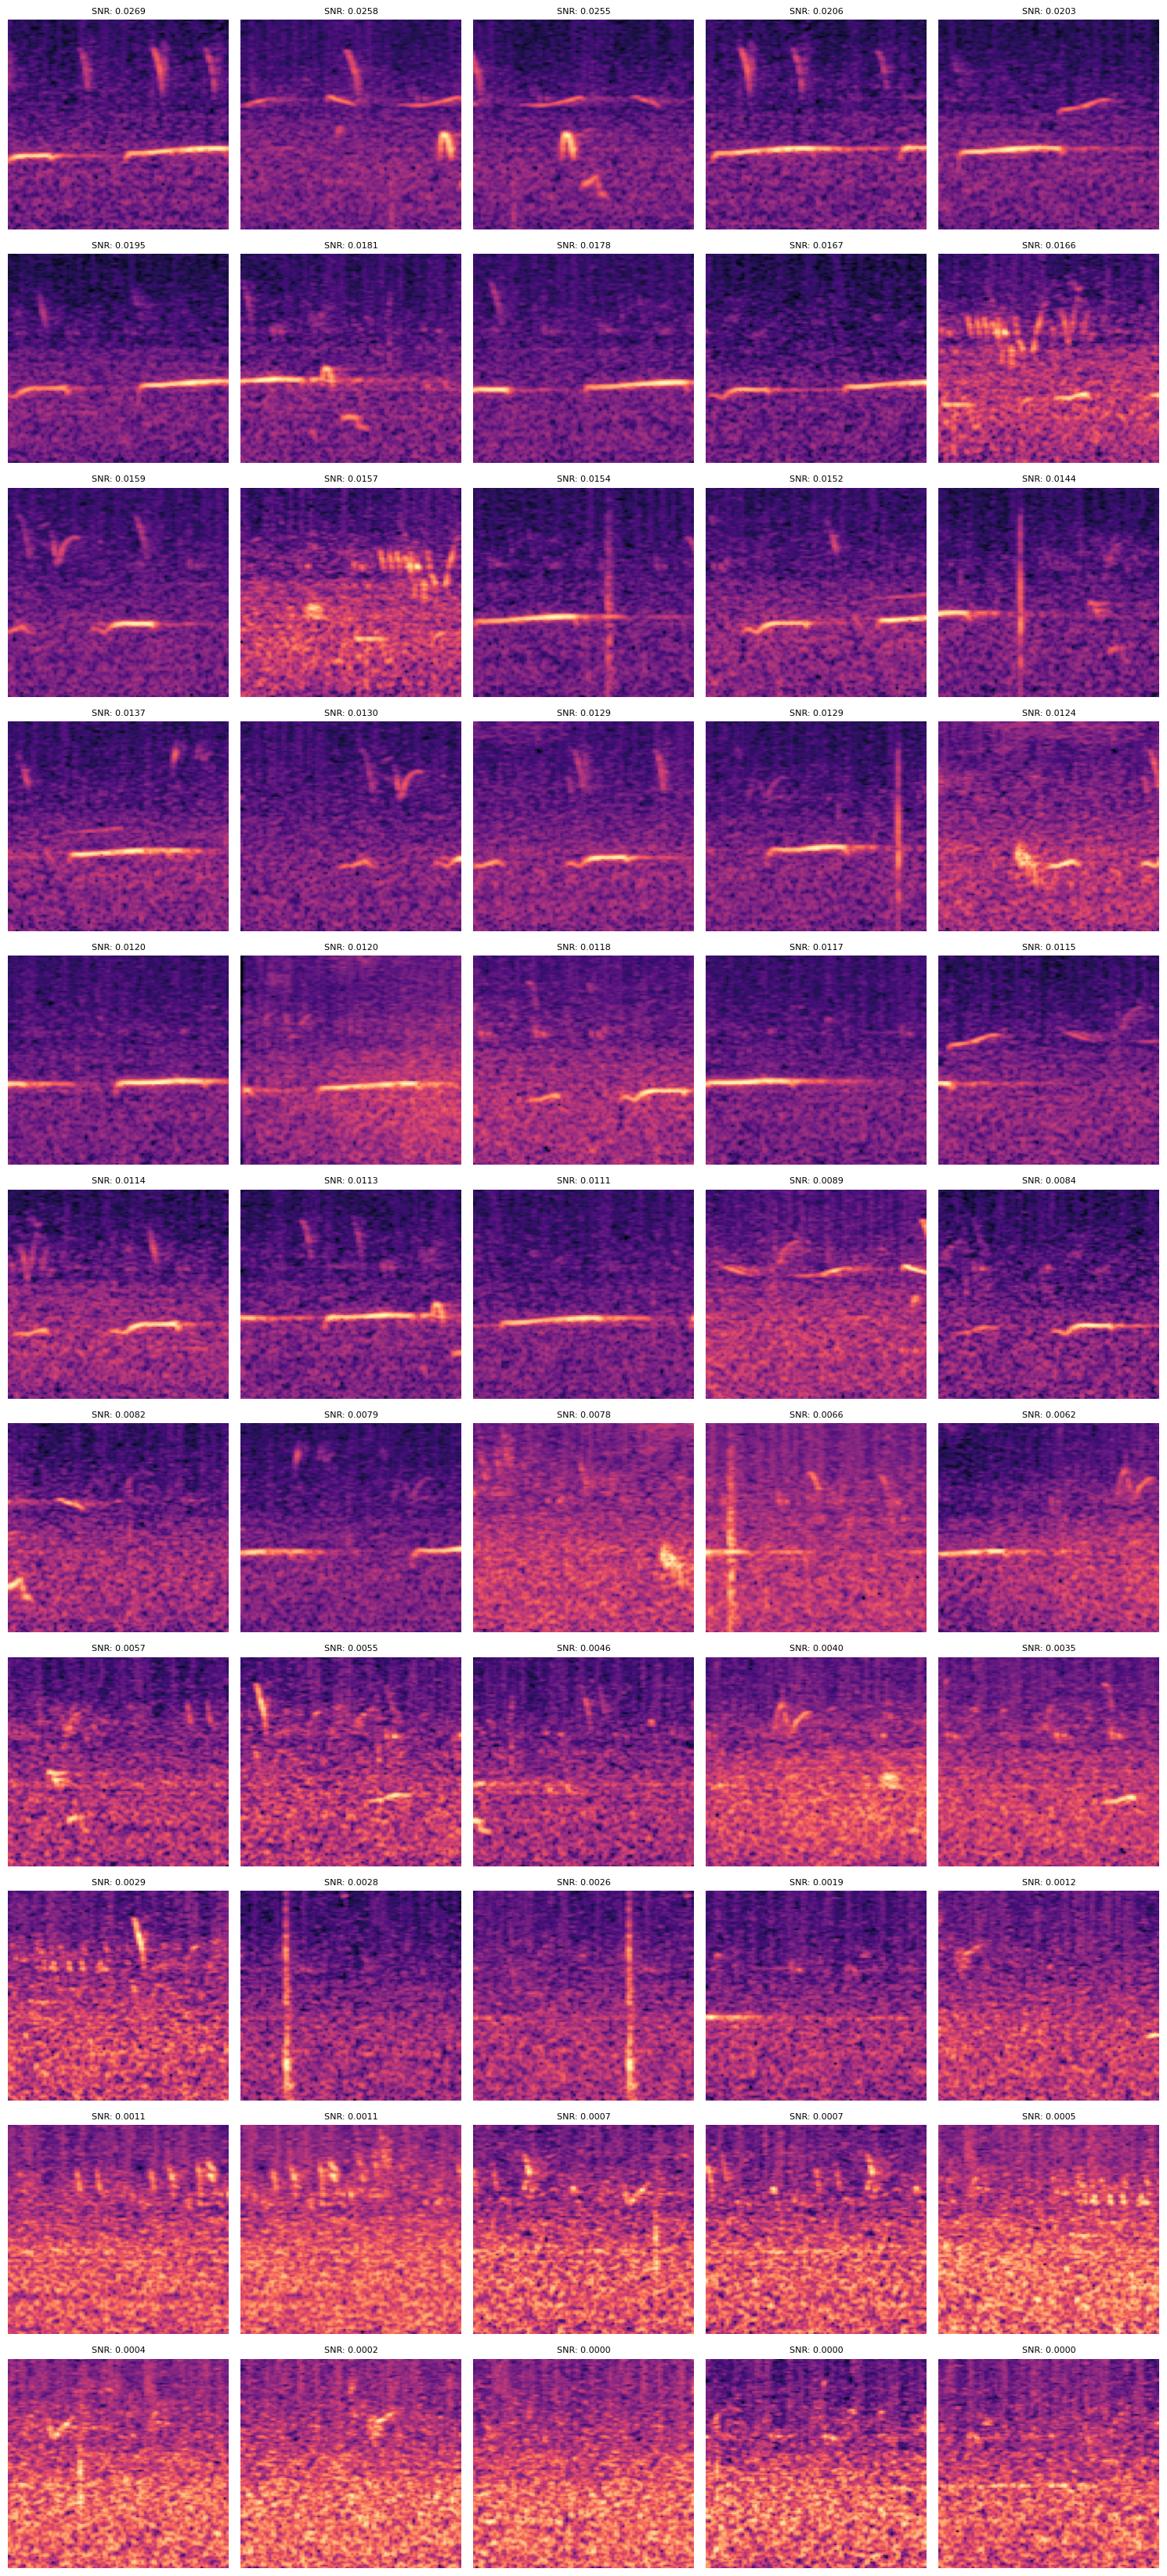

In [6]:
test_chunking_single_spectrogram(
    file_path="../data/processed_audio/npy_spectrograms/Black Cuckoo/Black_Cuckoo_09.npy",
    output_root="../data/processed_audio/test_chunks",
    chunk_size=86,
    stride=43,
    snr_threshold=0.1
)

plot_chunks_from_metadata('../data/processed_audio/test_chunks/Black_Cuckoo_09_metadata.csv')

In [ ]:
def chunk_and_filter_spectrograms(
    input_root,
    output_root,
    metadata_path,
    chunk_size=86,
    stride=43,
    snr_threshold=0.01,
    low_snr_keep_prob=0.1,
):
    os.makedirs(output_root, exist_ok=True)
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)

    metadata_records = []

    for species in tqdm(os.listdir(input_root)):
        species_dir = os.path.join(input_root, species)
        if not os.path.isdir(species_dir):
            continue

        output_species_dir = os.path.join(output_root, species)
        os.makedirs(output_species_dir, exist_ok=True)

        for npy_file in os.listdir(species_dir):
            if not npy_file.endswith(".npy"):
                continue

            spec_path = os.path.join(species_dir, npy_file)
            spec = np.load(spec_path)

            num_frames = spec.shape[1]
            chunk_idx = 0

            for start in range(0, num_frames - chunk_size + 1, stride):
                chunk = spec[:, start:start + chunk_size]
                s2n = signal2noise_logspec_median(chunk)

                if s2n >= snr_threshold:
                    label = species
                    save_chunk = True
                else:
                    # low SNR chunk: keep with 10% probability as noise
                    if random.random() < low_snr_keep_prob:
                        label = "noise"
                        save_chunk = True
                    else:
                        save_chunk = False

                if save_chunk:
                    chunk_filename = f"{os.path.splitext(npy_file)[0]}_chunk{chunk_idx}.npy"
                    chunk_path = os.path.join(output_root, label, chunk_filename)
                    os.makedirs(os.path.dirname(chunk_path), exist_ok=True)
                    np.save(chunk_path, chunk)

                    metadata_records.append({
                        "original_file": npy_file,
                        "chunk_index": chunk_idx,
                        "start_frame": start,
                        "end_frame": start + chunk_size,
                        "snr": s2n,
                        "species": label,
                        "chunk_path": chunk_path
                    })

                    chunk_idx += 1

    # Save metadata
    df = pd.DataFrame(metadata_records)
    df.to_csv(metadata_path, index=False)
    print(f"\nSaved metadata to {metadata_path}")

In [8]:

input_root = "../data/processed_audio/npy_spectrograms"
output_root = "../data/processed_audio/chunked_spectrograms"
metadata_path = "../data/metadata/chunk_metadata.csv"

chunk_and_filter_spectrograms(input_root, output_root, metadata_path)

100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Saved metadata to ../data/metadata/chunk_metadata.csv


In [13]:
# Source and destination directories
SRC_DIR = Path("../data/processed_audio/chunked_spectrograms")
DEST_DIR = Path("../data/processed_audio/flattened_chunked_spectrograms")
DEST_DIR.mkdir(exist_ok=True)

# Copy each .npy file from subdirectories into the new flat directory
for subdir in SRC_DIR.iterdir():
    if subdir.is_dir():
        for npy_file in subdir.glob("*.npy"):
            dest_path = DEST_DIR / npy_file.name
            shutil.copy2(npy_file, dest_path)


#### Inspect Metadata

In [17]:
metadata_df = pd.read_csv('../data/metadata/chunk_metadata.csv')
metadata_df.head()

original_file  chunk_index  start_frame  end_frame  \
0  Chestnut-vented_Warbler_34.npy            0            0        128   
1  Chestnut-vented_Warbler_34.npy            1           64        192   
2  Chestnut-vented_Warbler_34.npy            2          128        256   
3  Chestnut-vented_Warbler_34.npy            3          192        320   
4  Chestnut-vented_Warbler_34.npy            4          256        384   

        snr                  species  \
0  0.035889  Chestnut-vented Warbler   
1  0.074707  Chestnut-vented Warbler   
2  0.093933  Chestnut-vented Warbler   
3  0.117065  Chestnut-vented Warbler   
4  0.141174  Chestnut-vented Warbler   

                                          chunk_path  
0  ../data/processed_audio/chunked_spectrograms/C...  
1  ../data/processed_audio/chunked_spectrograms/C...  
2  ../data/processed_audio/chunked_spectrograms/C...  
3  ../data/processed_audio/chunked_spectrograms/C...  
4  ../data/processed_audio/chunked_spectrograms/C...

#### Make Train/Val/Test splits

In [20]:
# Split into train/val/test (e.g., 60/20/20), strtified along species label since data is limited
train_df, test_df = train_test_split(metadata_df, test_size=0.2, random_state=1992, stratify=metadata_df['species'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=1992, stratify=test_df['species'])

# Add split column
metadata_df["split"] = None
metadata_df.loc[train_df.index, "split"] = "train"
metadata_df.loc[val_df.index, "split"] = "val"
metadata_df.loc[test_df.index, "split"] = "test"

metadata_df.head()

original_file  chunk_index  start_frame  end_frame  \
0  Chestnut-vented_Warbler_34.npy            0            0        128   
1  Chestnut-vented_Warbler_34.npy            1           64        192   
2  Chestnut-vented_Warbler_34.npy            2          128        256   
3  Chestnut-vented_Warbler_34.npy            3          192        320   
4  Chestnut-vented_Warbler_34.npy            4          256        384   

        snr                  species  \
0  0.035889  Chestnut-vented Warbler   
1  0.074707  Chestnut-vented Warbler   
2  0.093933  Chestnut-vented Warbler   
3  0.117065  Chestnut-vented Warbler   
4  0.141174  Chestnut-vented Warbler   

                                          chunk_path  split  
0  ../data/processed_audio/chunked_spectrograms/C...  train  
1  ../data/processed_audio/chunked_spectrograms/C...    val  
2  ../data/processed_audio/chunked_spectrograms/C...  train  
3  ../data/processed_audio/chunked_spectrograms/C...    val  
4  ../data/processed_audio/chunked_spectrograms/C...  train